In [1]:
!nvidia-smi

Thu Jan  2 14:50:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.36                 Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   36C    P0              9W /   35W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Cell 1: Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision import transforms
from torchvision.datasets import MNIST

In [3]:

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# Cell 2: Load the dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

train_dataset = MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = MNIST(root="./data", train=False, transform=transform, download=True)

# Split train dataset into training and validation
val_size = 200
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


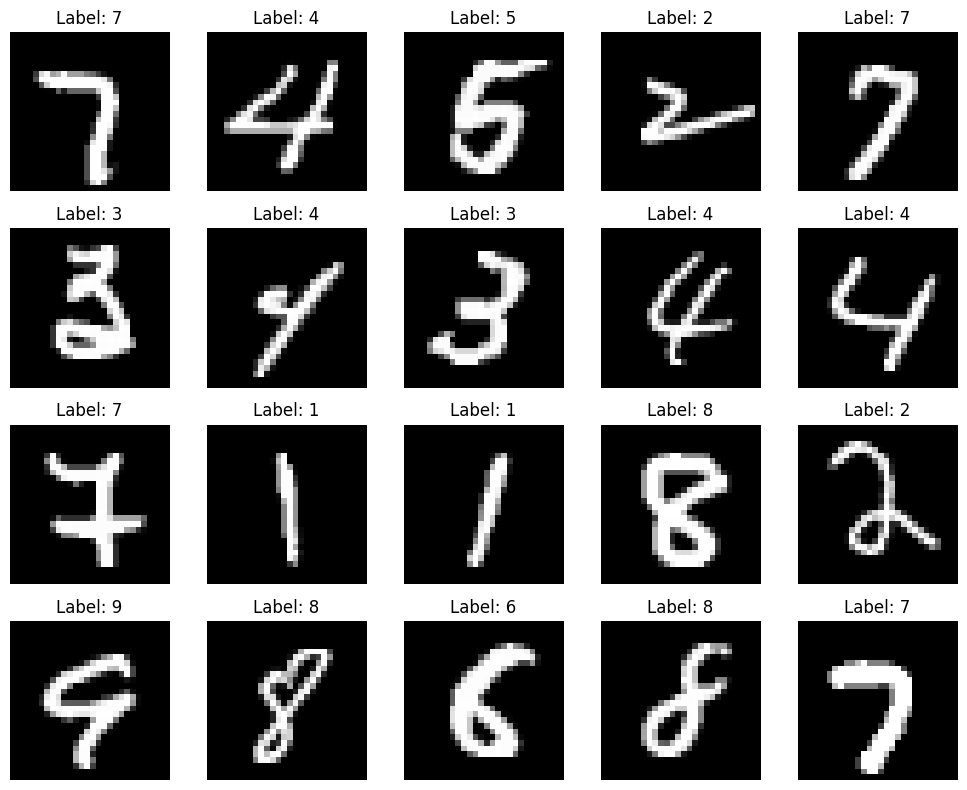

In [5]:
# Cell 3: Visualize some random images
examples = iter(train_loader)
example_data, example_targets = next(examples)
plt.figure(figsize=(10, 8))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(example_data[i][0], cmap='gray')
    plt.title(f"Label: {example_targets[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
# Cell 4: Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 14 * 14, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

model = CNN().to(device)

In [7]:
# Cell 5: Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [8]:
# Cell 6: Train the model
epochs = 25
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(epochs):
    model.train()
    train_loss, correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accs.append(correct / len(train_dataset))

    # Validation
    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(correct / len(val_dataset))

    print(f"Epoch {epoch+1}/{epochs}: Train Loss={train_losses[-1]:.4f}, Val Loss={val_losses[-1]:.4f}, Train Acc={train_accs[-1]*100:.2f}%, Val Acc={val_accs[-1]*100:.2f}%")


Epoch 1/25: Train Loss=0.3961, Val Loss=0.1612, Train Acc=91.26%, Val Acc=96.50%
Epoch 2/25: Train Loss=0.1055, Val Loss=0.1076, Train Acc=97.34%, Val Acc=98.00%


KeyboardInterrupt: 

Text(0.5, 1.0, 'Accuracy')

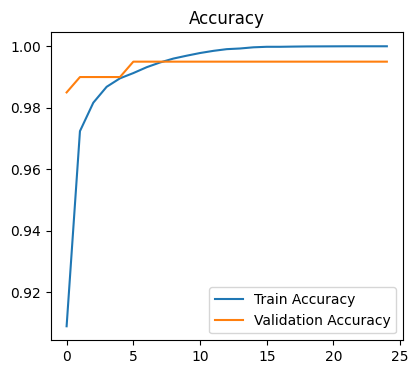

In [9]:
# Cell 7: Plot training progress
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')


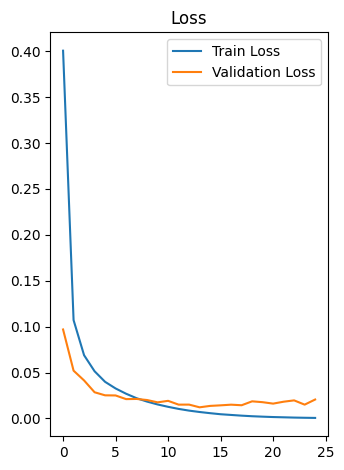

In [10]:
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.tight_layout()
plt.show()


In [11]:
# Cell 8: Evaluate the model on test data
model.eval()
test_loss, correct = 0, 0
y_true, y_pred = [], []

In [12]:
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(outputs.argmax(1).cpu().numpy())

print(f"Test Accuracy: {correct / len(test_dataset) * 100:.2f}%")


Test Accuracy: 99.12%


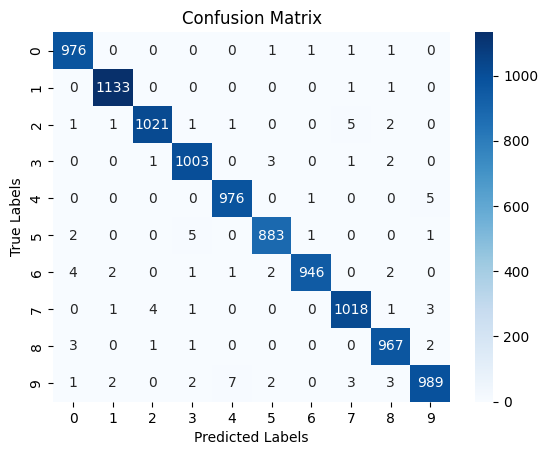

In [13]:
# Cell 9: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [14]:
# Cell 10: Precision, Recall, F1-Score
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



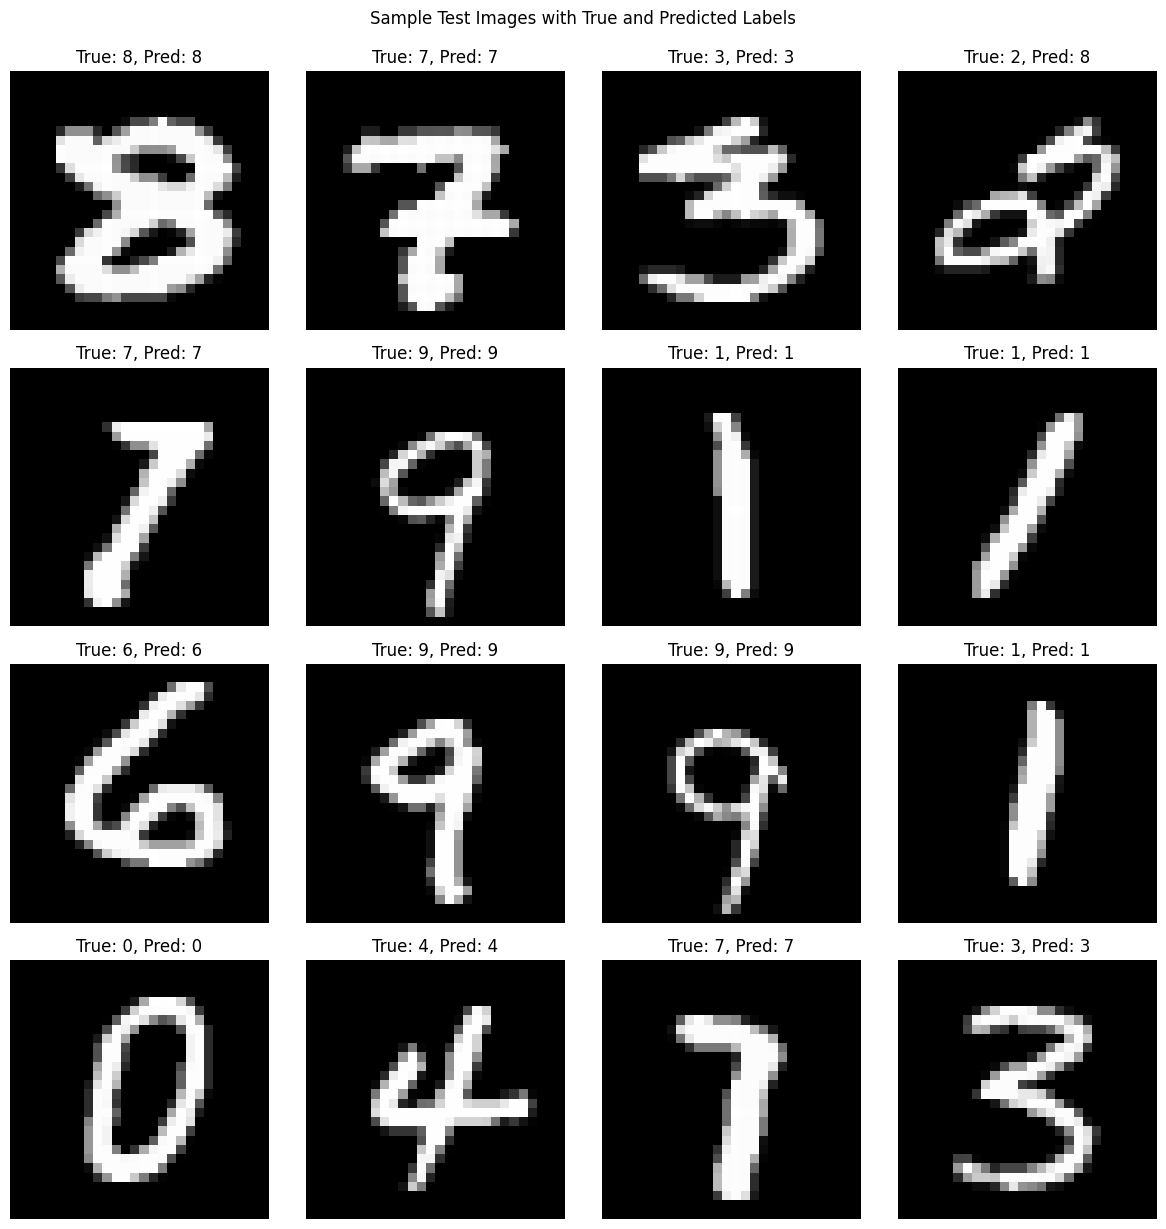

In [15]:
# Cell 11: Visualize some test samples with predictions
num_display = 16
indices = np.random.choice(len(test_dataset), num_display, replace=False)
plt.figure(figsize=(12, 12))

for i, idx in enumerate(indices):
    image, label = test_dataset[idx]
    image = image.unsqueeze(0).to(device)
    pred = model(image).argmax(1).item()

    plt.subplot(4, 4, i + 1)
    plt.imshow(image.cpu().squeeze(), cmap='gray')
    plt.title(f"True: {label}, Pred: {pred}")
    plt.axis('off')

plt.tight_layout()
plt.suptitle('Sample Test Images with True and Predicted Labels', y=1.02)
plt.show()